In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

from surprise import Dataset, Reader, SVD
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise.accuracy import mse, mae, rmse
from surprise import accuracy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

np.random.seed(29)
torch.manual_seed(29)

ModuleNotFoundError: No module named 'pandas'

## EDA

In [2]:
rating_df = pd.read_csv('data\ml-latest-small/ratings.csv')
movies_data = pd.read_csv('data\ml-latest-small/movies.csv')

print("Rating dataset shape:", rating_df.shape)
print("Movies dataset shape:", movies_data.shape)

Rating dataset shape: (100836, 4)
Movies dataset shape: (9742, 3)


In [3]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
rating_df.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
print(f"\nRating range: {rating_df['rating'].min()} - {rating_df['rating'].max()}")
print(f"Number of unique users: {rating_df['userId'].nunique()}")
print(f"Number of unique movies: {rating_df['movieId'].nunique()}")
print(f"Total ratings: {len(rating_df)}")


Rating range: 0.5 - 5.0
Number of unique users: 610
Number of unique movies: 9724
Total ratings: 100836


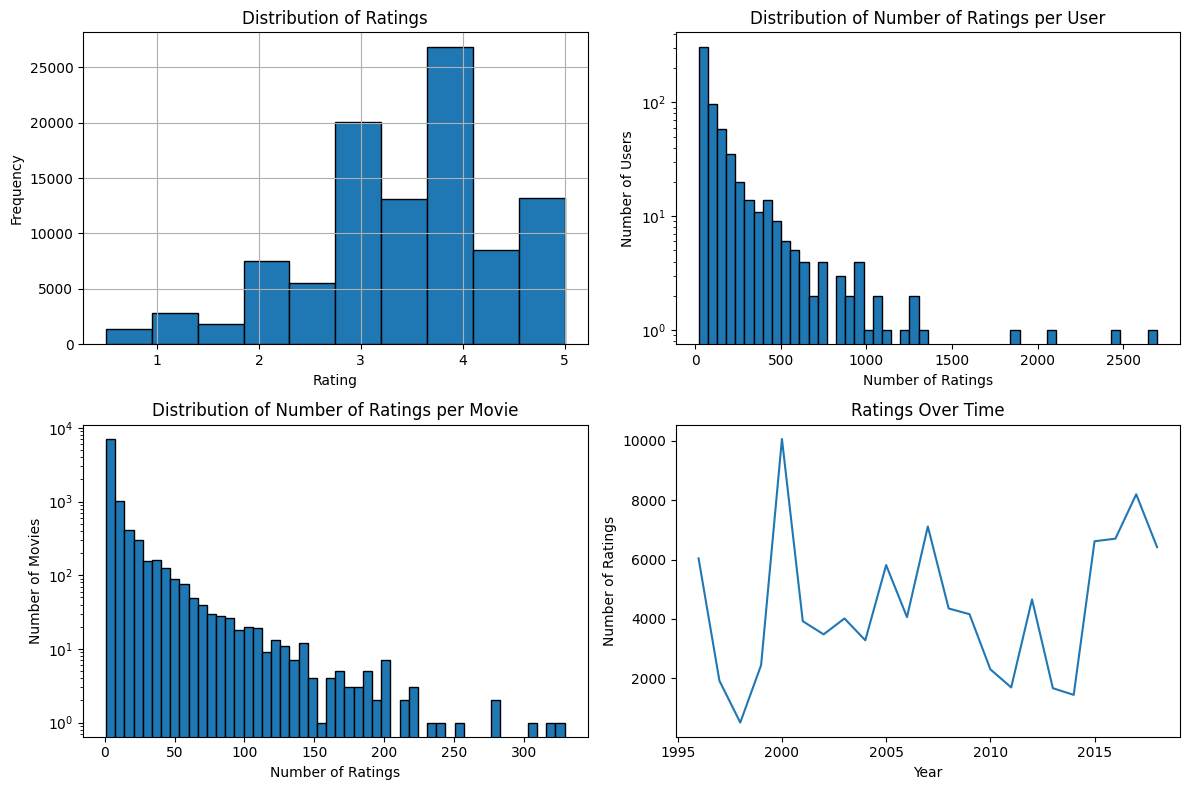

In [7]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
rating_df['rating'].hist(bins=10, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
user_rating_counts = rating_df['userId'].value_counts()
plt.hist(user_rating_counts, bins=50, edgecolor='black')
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.yscale('log')

plt.subplot(2, 2, 3)
movie_rating_counts = rating_df['movieId'].value_counts()
plt.hist(movie_rating_counts, bins=50, edgecolor='black')
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.yscale('log')

plt.subplot(2, 2, 4)
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], unit='s')
rating_df['year'] = rating_df['timestamp'].dt.year
yearly_ratings = rating_df['year'].value_counts().sort_index()
yearly_ratings.plot(kind='line')
plt.title('Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')

plt.tight_layout()
plt.show()

In [8]:
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [10]:
movies_data.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [11]:
all_genres = []
for genres in movies_data['genres'].dropna():
    if genres != '(no genres listed)':
        all_genres.extend(genres.split('|'))

genre_counts = pd.Series(all_genres).value_counts()
print(f"\nTotal unique genres: {len(genre_counts)}")
print("\nTop 10 genres:")
print(genre_counts.head(10))


Total unique genres: 19

Top 10 genres:
Drama        4361
Comedy       3756
Thriller     1894
Action       1828
Romance      1596
Adventure    1263
Crime        1199
Sci-Fi        980
Horror        978
Fantasy       779
Name: count, dtype: int64


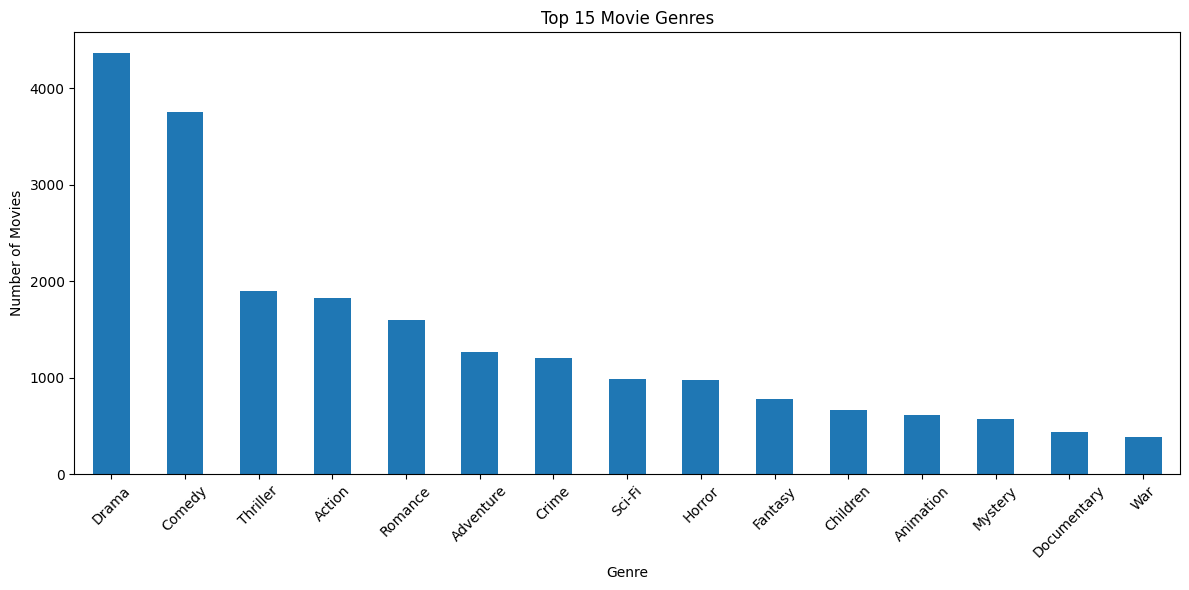

In [12]:
plt.figure(figsize=(12, 6))
genre_counts.head(15).plot(kind='bar')
plt.title('Top 15 Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
total_possible_ratings = rating_df['userId'].nunique() * rating_df['movieId'].nunique()
actual_ratings = len(rating_df)
sparsity = (1 - actual_ratings / total_possible_ratings) * 100
print(f"\nData sparsity: {sparsity:.2f}%")


Data sparsity: 98.30%


In [14]:
print(f"\nAverage ratings per user: {rating_df.groupby('userId').size().mean():.2f}")
print(f"Average ratings per movie: {rating_df.groupby('movieId').size().mean():.2f}")


Average ratings per user: 165.30
Average ratings per movie: 10.37


In [15]:
most_rated = rating_df.groupby('movieId').size().sort_values(ascending=False).head(10)
most_rated_with_titles = most_rated.reset_index()
most_rated_with_titles = most_rated_with_titles.merge(movies_data[['movieId', 'title']], on='movieId')
print("\nMost rated movies:")
print(most_rated_with_titles)


Most rated movies:
   movieId    0                                      title
0      356  329                        Forrest Gump (1994)
1      318  317           Shawshank Redemption, The (1994)
2      296  307                        Pulp Fiction (1994)
3      593  279           Silence of the Lambs, The (1991)
4     2571  278                         Matrix, The (1999)
5      260  251  Star Wars: Episode IV - A New Hope (1977)
6      480  238                       Jurassic Park (1993)
7      110  237                          Braveheart (1995)
8      589  224          Terminator 2: Judgment Day (1991)
9      527  220                    Schindler's List (1993)


In [16]:
avg_ratings = rating_df.groupby('movieId').agg({'rating': ['mean', 'count']}).round(2)
avg_ratings.columns = ['avg_rating', 'num_ratings']
avg_ratings = avg_ratings.reset_index()
popular_movies = avg_ratings[avg_ratings['num_ratings'] >= 50].sort_values('avg_rating', ascending=False).head(10)
popular_movies = popular_movies.merge(movies_data[['movieId', 'title']], on='movieId')
print("\nHighest rated movies (min 50 ratings):")
print(popular_movies)


Highest rated movies (min 50 ratings):
   movieId  avg_rating  num_ratings  \
0      318        4.43          317   
1      858        4.29          192   
2      750        4.27           97   
3     1276        4.27           57   
4     2959        4.27          218   
5     1221        4.26          129   
6      904        4.26           84   
7    48516        4.25          107   
8     1213        4.25          126   
9    58559        4.24          149   

                                               title  
0                   Shawshank Redemption, The (1994)  
1                              Godfather, The (1972)  
2  Dr. Strangelove or: How I Learned to Stop Worr...  
3                              Cool Hand Luke (1967)  
4                                  Fight Club (1999)  
5                     Godfather: Part II, The (1974)  
6                                 Rear Window (1954)  
7                               Departed, The (2006)  
8                                  

## Data Prepration

In [17]:
rating_df['timestamp'] = rating_df['timestamp'].astype('int64')

print("Data quality check:")
print(f"Duplicate ratings: {rating_df.duplicated().sum()}")
print(f"Users with only 1 rating: {sum(rating_df.groupby('userId').size() == 1)}")
print(f"Movies with only 1 rating: {sum(rating_df.groupby('movieId').size() == 1)}")

Data quality check:
Duplicate ratings: 0
Users with only 1 rating: 0
Movies with only 1 rating: 3446


Filter out users and movies with very few ratings for better model performance

In [18]:
min_user_ratings = 20
min_movie_ratings = 20

user_counts = rating_df['userId'].value_counts()
movie_counts = rating_df['movieId'].value_counts()

valid_users = user_counts[user_counts >= min_user_ratings].index
valid_movies = movie_counts[movie_counts >= min_movie_ratings].index

filtered_ratings = rating_df[
    (rating_df['userId'].isin(valid_users)) & 
    (rating_df['movieId'].isin(valid_movies))
]

print(f"\nAfter filtering:")
print(f"Original ratings: {len(rating_df)}")
print(f"Filtered ratings: {len(filtered_ratings)}")
print(f"Users: {rating_df['userId'].nunique()} -> {filtered_ratings['userId'].nunique()}")
print(f"Movies: {rating_df['movieId'].nunique()} -> {filtered_ratings['movieId'].nunique()}")


After filtering:
Original ratings: 100836
Filtered ratings: 67898
Users: 610 -> 610
Movies: 9724 -> 1297


In [19]:
rating_df_clean = filtered_ratings.copy()

Create user and movie encoders for neural networks


In [20]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

rating_df_clean['user_encoded'] = user_encoder.fit_transform(rating_df_clean['userId'])
rating_df_clean['movie_encoded'] = movie_encoder.fit_transform(rating_df_clean['movieId'])

n_users = rating_df_clean['user_encoded'].nunique()
n_movies = rating_df_clean['movie_encoded'].nunique()

print(f"\nEncoded dimensions:")
print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")


Encoded dimensions:
Number of users: 610
Number of movies: 1297


Split data for neural network models


In [21]:
train_data, test_data = sklearn_train_test_split(rating_df_clean, test_size=0.2, random_state=42)

print(f"\nTrain set size: {len(train_data)}")
print(f"Test set size: {len(test_data)}")


Train set size: 54318
Test set size: 13580


Prepare data for Surprise library


In [22]:
reader = Reader(rating_scale=(0.5, 5.0))
surprise_data = Dataset.load_from_df(rating_df_clean[['userId', 'movieId', 'rating']], reader)

## Factorization Machines

In [23]:
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=29)

In [24]:
svd_model = SVD(n_factors=100, n_epochs=20, biased=True, random_state=42)
svd_model.fit(trainset)

In [25]:
svd_predictions = svd_model.test(testset)

In [26]:
svd_rmse = rmse(svd_predictions, verbose=False)
svd_mae = mae(svd_predictions, verbose=False)

print(f"SVD RMSE: {svd_rmse:.4f}")
print(f"SVD MAE: {svd_mae:.4f}")

SVD RMSE: 0.8383
SVD MAE: 0.6421


In [27]:
cv_results = cross_validate(svd_model, surprise_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
print(f"Cross-validation RMSE: {cv_results['test_rmse'].mean():.4f}")
print(f"Cross-validation MAE: {cv_results['test_mae'].mean():.4f}")

Cross-validation RMSE: 0.8450
Cross-validation MAE: 0.6469


In [28]:
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)
print("SVD model saved as 'svd_model.pkl'")

SVD model saved as 'svd_model.pkl'


## Neural Collaborative Filtering

In [29]:
def create_dataset(data):
    users = torch.LongTensor(data['user_encoded'].values)
    movies = torch.LongTensor(data['movie_encoded'].values)
    ratings = torch.FloatTensor(data['rating'].values)
    return TensorDataset(users, movies, ratings)

In [30]:
train_dataset = create_dataset(train_data)
test_dataset = create_dataset(test_data)

In [31]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [32]:
class NCF(nn.Module):
    def __init__(self, n_users, n_movies, n_factors=50, hidden_units=[128, 64], dropout=0.2):
        super(NCF, self).__init__()
        
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.movie_embedding = nn.Embedding(n_movies, n_factors)
        self.fc_layers = nn.ModuleList()
        input_size = n_factors * 2
        
        for hidden_size in hidden_units:
            self.fc_layers.append(nn.Linear(input_size, hidden_size))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(dropout))
            input_size = hidden_size
        
        self.output_layer = nn.Linear(input_size, 1)
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Embedding):
                nn.init.normal_(layer.weight, std=0.01)
            elif isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, user_ids, movie_ids):
        user_emb = self.user_embedding(user_ids)
        movie_emb = self.movie_embedding(movie_ids)
        
        x = torch.cat([user_emb, movie_emb], dim=1)
        for layer in self.fc_layers:
            x = layer(x)
    
        rating = self.output_layer(x)
        return rating.squeeze()

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ncf_model = NCF(n_users, n_movies, n_factors=64, hidden_units=[128, 64, 32]).to(device)

In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(ncf_model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

In [ ]:
n_epochs = 20
train_losses = []
test_losses = []

In [36]:
for epoch in range(n_epochs):

    ncf_model.train()
    train_loss = 0
    for batch_users, batch_movies, batch_ratings in train_loader:
        batch_users = batch_users.to(device)
        batch_movies = batch_movies.to(device)
        batch_ratings = batch_ratings.to(device)
        
        optimizer.zero_grad()
        predictions = ncf_model(batch_users, batch_movies)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    ncf_model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_users, batch_movies, batch_ratings in test_loader:
            batch_users = batch_users.to(device)
            batch_movies = batch_movies.to(device)
            batch_ratings = batch_ratings.to(device)
            
            predictions = ncf_model(batch_users, batch_movies)
            loss = criterion(predictions, batch_ratings)
            test_loss += loss.item()
    
    scheduler.step()
    
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 5/30, Train Loss: 1.0236, Test Loss: 0.7304
Epoch 10/30, Train Loss: 0.9257, Test Loss: 0.7094
Epoch 15/30, Train Loss: 0.8608, Test Loss: 0.6951
Epoch 20/30, Train Loss: 0.8006, Test Loss: 0.6951
Epoch 25/30, Train Loss: 0.7420, Test Loss: 0.7045
Epoch 30/30, Train Loss: 0.6861, Test Loss: 0.7148


In [37]:
ncf_model.eval()
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_users, batch_movies, batch_ratings in test_loader:
        batch_users = batch_users.to(device)
        batch_movies = batch_movies.to(device)
        batch_ratings = batch_ratings.to(device)
        
        predictions = ncf_model(batch_users, batch_movies)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(batch_ratings.cpu().numpy())

ncf_rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
ncf_mae = mean_absolute_error(all_targets, all_predictions)

print(f"\nNCF RMSE: {ncf_rmse:.4f}")
print(f"NCF MAE: {ncf_mae:.4f}")



NCF RMSE: 0.8481
NCF MAE: 0.6442


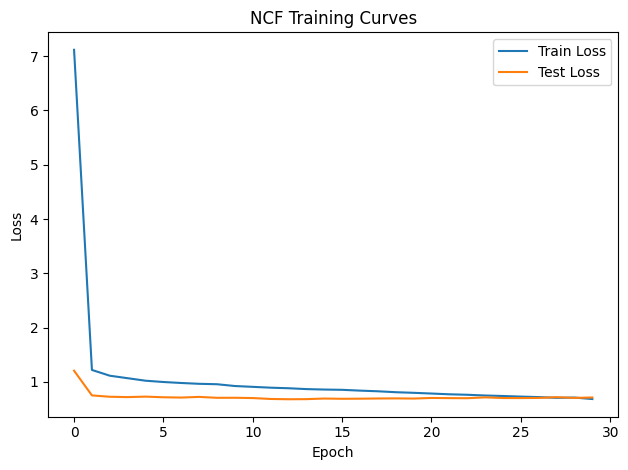

In [38]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('NCF Training Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
with open('ncf_model.pkl', 'wb') as f:
    pickle.dump(ncf_model, f)
print("NCF model saved as 'ncf_model.pkl'")

NCF model saved as 'ncf_model.pkl'


## Model Comaprison

In [40]:
models_comparison = pd.DataFrame({
    'Model': ['SVD (Factorization Machines)', 'Neural Collaborative Filtering'],
    'RMSE': [svd_rmse, ncf_rmse],
    'MAE': [svd_mae, ncf_mae]
})

print(models_comparison)

                            Model      RMSE       MAE
0    SVD (Factorization Machines)  0.838289  0.642128
1  Neural Collaborative Filtering  0.848134  0.644191


In [41]:
best_model_idx = models_comparison['RMSE'].idxmin()
best_model = models_comparison.iloc[best_model_idx]['Model']
print(f"\nBest performing model: {best_model}")


Best performing model: SVD (Factorization Machines)


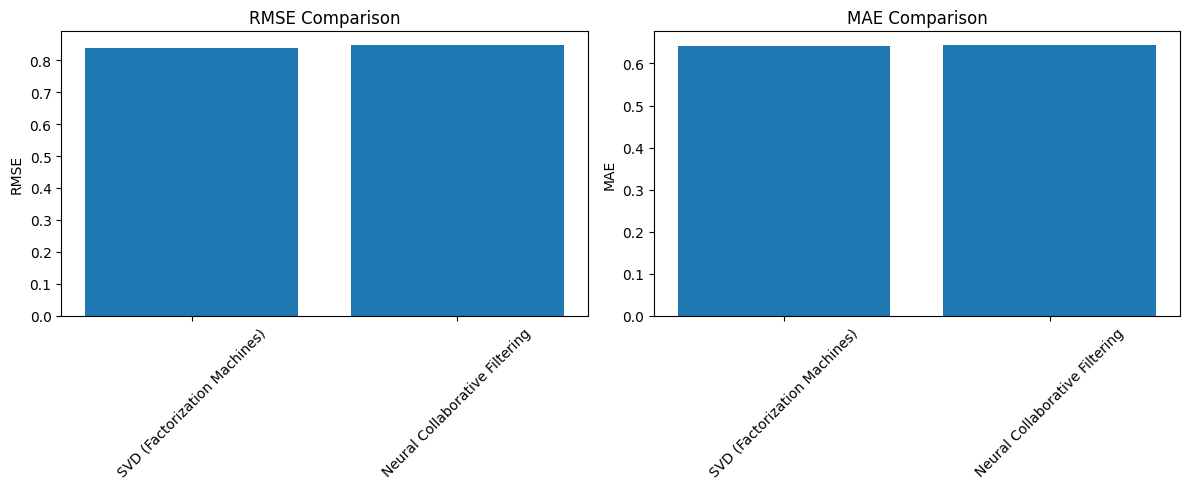

In [42]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(models_comparison['Model'], models_comparison['RMSE'])
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(models_comparison['Model'], models_comparison['MAE'])
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Item Based Collaborative Filtering

Merge ratings with movies data


In [43]:
movie_merge = pd.merge(rating_df_clean, movies_data, on='movieId')


Convert nanoseconds to seconds before converting to datetime

In [44]:
movie_merge['timestamp'] = movie_merge['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x / 1e9))
movie_merge = movie_merge[['userId', 'movieId', 'title', 'genres', 'timestamp', 'rating']]

print("Movie merge dataset shape:", movie_merge.shape)
movie_merge.head()

Movie merge dataset shape: (67898, 6)


,userId,movieId,title,genres,timestamp,rating
0,1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2000-07-30 18:45:03,4.0
1,1,3,Grumpier Old Men (1995),Comedy|Romance,2000-07-30 18:20:47,4.0
2,1,6,Heat (1995),Action|Crime|Thriller,2000-07-30 18:37:04,4.0
3,1,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,2000-07-30 19:03:35,5.0
4,1,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,2000-07-30 18:48:51,5.0


In [45]:
movie_merge['genres'] = movie_merge['genres'].fillna('(no genres listed)')
movie_merge['genres'] = movie_merge['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

In [46]:
mlb = MultiLabelBinarizer()
genre_onehot = pd.DataFrame(
    mlb.fit_transform(movie_merge['genres']),
    columns=mlb.classes_,
    index=movie_merge.index
)

print(f"Genre features shape: {genre_onehot.shape}")
print(f"Available genres: {list(mlb.classes_)}")

Genre features shape: (67898, 19)
Available genres: ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [47]:
genre_onehot['movieId'] = movie_merge['movieId']
genre_onehot['rating'] = movie_merge['rating']

Create features for similarity calculation (genres + average rating)

In [48]:
genre_features = genre_onehot.groupby('movieId').agg({
    **{col: 'max' for col in mlb.classes_},
    'rating': 'mean'
}).round(3)

print(f"Feature matrix shape: {genre_features.shape}")

Feature matrix shape: (1297, 20)


In [49]:
similarity_matrix = cosine_similarity(genre_features)
similarity_df = pd.DataFrame(
    similarity_matrix, 
    index=genre_features.index, 
    columns=genre_features.index
)

print(f"Similarity matrix shape: {similarity_matrix.shape}")

Similarity matrix shape: (1297, 1297)


In [50]:
def get_item_recommendations(movie_title, top_n=10):
    
    movie_info = movie_merge[movie_merge['title'].str.contains(movie_title, case=False, na=False)]
    
    if movie_info.empty:
        print(f"Movie '{movie_title}' not found!")
        return None
    
    movie_id = movie_info['movieId'].iloc[0]
    actual_title = movie_info['title'].iloc[0]
        
    if movie_id not in similarity_df.index:
        print(f"Movie ID {movie_id} not found in similarity matrix!")
        return None
    
    # Get similarity scores
    sim_scores = similarity_df[movie_id].sort_values(ascending=False)
    
    # Remove the movie itself and get top recommendations
    sim_scores = sim_scores.loc[sim_scores.index != movie_id].head(top_n)
    recommended_movie_ids = sim_scores.index.tolist()
    
    # Get movie details
    recommendations = movie_merge[movie_merge['movieId'].isin(recommended_movie_ids)]
    recommendations = recommendations.drop_duplicates(subset='movieId')
    
    # Add similarity scores
    recommendations = recommendations.set_index('movieId').loc[recommended_movie_ids].reset_index()
    recommendations['similarity_score'] = sim_scores.values
    
    # Calculate average ratings
    avg_ratings = movie_merge.groupby('movieId')['rating'].agg(['mean', 'count']).round(2)
    avg_ratings.columns = ['avg_rating', 'num_ratings']
    recommendations = recommendations.merge(avg_ratings, on='movieId', how='left')
    
    return recommendations[['movieId', 'title', 'genres', 'similarity_score', 'avg_rating', 'num_ratings']]

In [51]:
popular_movies_sample = movie_merge.groupby(['movieId', 'title']).size().sort_values(ascending=False).head(20)
print("Popular movies for testing:")
print(popular_movies_sample.head(10))

Popular movies for testing:
movieId  title                                    
356      Forrest Gump (1994)                          329
318      Shawshank Redemption, The (1994)             317
296      Pulp Fiction (1994)                          307
593      Silence of the Lambs, The (1991)             279
2571     Matrix, The (1999)                           278
260      Star Wars: Episode IV - A New Hope (1977)    251
480      Jurassic Park (1993)                         238
110      Braveheart (1995)                            237
589      Terminator 2: Judgment Day (1991)            224
527      Schindler's List (1993)                      220
dtype: int64


In [52]:
test_movie = "Toy Story"
recommendations = get_item_recommendations(test_movie, top_n=10)

if recommendations is not None:
    print(f"\nTop 10 recommendations for '{test_movie}':")

recommendations


Top 10 recommendations for 'Toy Story':


,movieId,title,genres,similarity_score,avg_rating,num_ratings
0,4886,"Monsters, Inc. (2001)","[Adventure, Animation, Children, Comedy, Fantasy]",0.999985,3.87,132
1,3114,Toy Story 2 (1999),"[Adventure, Animation, Children, Comedy, Fantasy]",0.999978,3.86,97
2,4016,"Emperor's New Groove, The (2000)","[Adventure, Animation, Children, Comedy, Fantasy]",0.999726,3.72,37
3,2294,Antz (1998),"[Adventure, Animation, Children, Comedy, Fantasy]",0.996371,3.24,45
4,53121,Shrek the Third (2007),"[Adventure, Animation, Children, Comedy, Fantasy]",0.992995,3.02,21
5,78499,Toy Story 3 (2010),"[Adventure, Animation, Children, Comedy, Fanta...",0.977713,4.11,55
6,108932,The Lego Movie (2014),"[Action, Adventure, Animation, Children, Comed...",0.975867,3.87,31
7,4306,Shrek (2001),"[Adventure, Animation, Children, Comedy, Fanta...",0.975838,3.87,170
8,134853,Inside Out (2015),"[Adventure, Animation, Children, Comedy, Drama...",0.975291,3.81,43
9,6377,Finding Nemo (2003),"[Adventure, Animation, Children, Comedy]",0.975142,3.96,141


In [53]:
test_movie2 = "Jurassic Park"
recommendations2 = get_item_recommendations(test_movie2, top_n=10)

if recommendations2 is not None:
    print(f"\nTop 10 recommendations for '{test_movie2}':")
recommendations2


Top 10 recommendations for 'Jurassic Park':


,movieId,title,genres,similarity_score,avg_rating,num_ratings
0,1374,Star Trek II: The Wrath of Khan (1982),"[Action, Adventure, Sci-Fi, Thriller]",0.999998,3.77,62
1,6333,X2: X-Men United (2003),"[Action, Adventure, Sci-Fi, Thriller]",0.999996,3.72,76
2,122882,Mad Max: Fury Road (2015),"[Action, Adventure, Sci-Fi, Thriller]",0.999972,3.82,47
3,2916,Total Recall (1990),"[Action, Adventure, Sci-Fi, Thriller]",0.999940,3.65,88
4,1356,Star Trek: First Contact (1996),"[Action, Adventure, Sci-Fi, Thriller]",0.999903,3.88,91
5,5349,Spider-Man (2002),"[Action, Adventure, Sci-Fi, Thriller]",0.999708,3.54,122
6,3703,"Road Warrior, The (Mad Max 2) (1981)","[Action, Adventure, Sci-Fi, Thriller]",0.999551,4.04,40
7,8644,"I, Robot (2004)","[Action, Adventure, Sci-Fi, Thriller]",0.999545,3.49,61
8,1127,"Abyss, The (1989)","[Action, Adventure, Sci-Fi, Thriller]",0.999483,3.48,62
9,1129,Escape from New York (1981),"[Action, Adventure, Sci-Fi, Thriller]",0.999369,3.45,39


In [54]:
if recommendations is not None:
    print(f"Average similarity score: {recommendations['similarity_score'].mean():.3f}")
    print(f"Average rating of recommendations: {recommendations['avg_rating'].mean():.3f}")
    print(f"Average number of ratings: {recommendations['num_ratings'].mean():.1f}")

Average similarity score: 0.987
Average rating of recommendations: 3.733
Average number of ratings: 77.2
